Image captioning, a complex task that requires creating accurate and contextually relevant textual descriptions for images, has evolved significantly over time. Initially, image captioning models primarily utilized computer vision techniques, which often fell short in grasping the complex semantics and relationships within images. The incorporation of natural language processing techniques heralded a significant shift, enhancing the development of models that are more sophisticated and capable of understanding context in a nuanced manner.

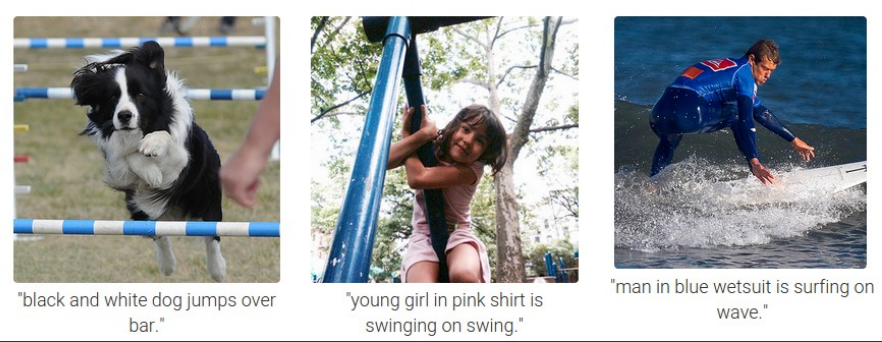

###Florence-2
Florence-2 is MIT-licensed, multimodal vision model released by Microsoft Research, supports generating image captions of varying degrees of richness. Florence-2 is a sophisticated vision foundation model that operates using a prompt-based system to manage a variety of tasks related to vision and vision-language. It can interpret straightforward text prompts for operations such as captioning, object detection, and segmentation. Utilizing the FLD-5B dataset, which comprises over 5.4 billion annotations from 126 million images, Florence-2 excels at multi-task learning. Its sequence-to-sequence architecture is well-suited for both zero-shot applications and fine-tuned scenarios, establishing its status as a formidable player in the vision foundation model arena.

HuggingFace Transformers and the timm image package will be used to load Florence-2 for generating captions

In [1]:
import torch
print(torch.cuda.is_available())

False


In [2]:
#install the required dependencies
!pip install transformers timm flash_attn einops

  Obtaining dependency information for timm from https://files.pythonhosted.org/packages/e7/0e/ef97f6d8c399bf5842af0dd5a4f5ac55b2f169d62e29ecbf7663e1cb1438/timm-1.0.9-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 16.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [22 lines of output]
      fatal: not a git repository (or any of the parent directories): .git
      /private/var/folders/46/nnxtf31j4tx1mllsphpp6gjr0000gn/T/pip-install-kl9dnp1s/flash-attn_0de61d47594f4a5686358cf0cdc43585/setup.py:95: UserWarning: flash_attn was requested, but nvcc was not found.  Are you sure your environment has nvcc available?  If you're installing within a container from https://hub.docker.com/r/pytorch/pytorch, only images whose names contain 'devel'

In [3]:
from PIL import Image
import requests
from IPython.display import display
from transformers import AutoProcessor, AutoModelForCausalLM

def display_image(url):
  image = Image.open(requests.get(url, stream=True).raw)
  # Display the image
  display(image)
  return image

In [4]:
#load  the Florence-2 model
def load_model():
  model_id = 'microsoft/Florence-2-large'
  model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().cuda()
  processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
  return model, processor

def generate_captions(task_prompt,image, model, processor, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    #Process the input text and image using the specified processor
    inputs = processor(text=prompt, images=image, return_tensors="pt")
   #generate captions using the model
    generated_ids = model.generate(
        input_ids=inputs["input_ids"].cuda(),
        pixel_values=inputs["pixel_values"].cuda(),
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3, )
    # Decode the generated token IDs to text
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height))

    return answer[task_prompt]


In [5]:
model, processor=load_model()

config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

ImportError: This modeling file requires the following packages that were not found in your environment: flash_attn, timm, einops. Run `pip install flash_attn timm einops`

For generating a detailed caption of an image, the task type `<MORE_DETAILED_CAPTION>` is utilized. Alternatively, shorter captions can be produced using the `<CAPTION>` or `<DETAILED_CAPTION>` task types.

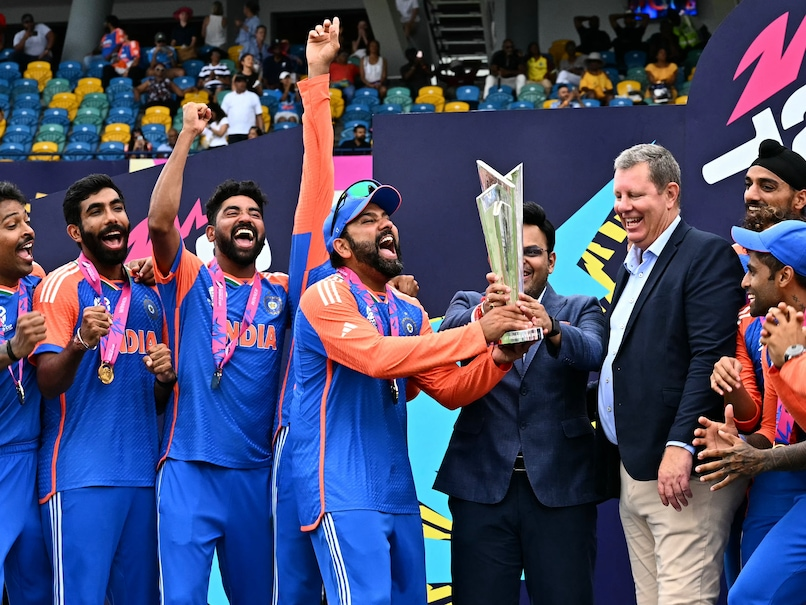

A group of men holding up a trophy in front of a crowd.


In [ ]:
#example 1
url = 'https://c.ndtvimg.com/2024-07/snujg7h_rohit-sharma-afp_625x300_01_July_24.jpg?im=FeatureCrop,algorithm=dnn,width=806,height=605'
image=display_image(url)

#prompt
task_prompt = "<CAPTION>"
answer = generate_captions(task_prompt,image, model, processor)
print(answer)

In [ ]:
#prompt 2
task_prompt = "<DETAILED_CAPTION>"
answer = generate_captions(task_prompt,image, model, processor)
print(answer)

The image shows the Indian cricket team celebrating with the trophy after winning the ICC Cricket World Cup. We can see a group of people standing on the ground, some of them holding the trophy, while others are clapping their hands in joy. In the background, there are people sitting on chairs, a banner with text on it, a staircase, a railing, and a wall.


In [ ]:

#prompt 3
task_prompt = "<MORE_DETAILED_CAPTION>"
answer = generate_captions(task_prompt,image, model, processor)
print(answer)

The image shows a group of Indian cricketers celebrating with the trophy after winning the ICC Cricket World Cup. The players are wearing blue jerseys and are standing on a stage with a large crowd of spectators in the background. The player in the center is holding the trophy up in the air with his arms raised in triumph. He is wearing a blue cap and is surrounded by his teammates, who are also wearing medals around their necks. On the right side of the image, there is a man in a suit and tie, who appears to be the coach or manager of the team. The image appears to have been taken at a cricket stadium, as there are banners and advertisements visible in the backdrop.
